In [ ]:
pip install helper

**Importing the important libraries**

In [ ]:
%matplotlib inline

import sys
sys.path.append("../")
import copy
import itertools
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import helper
import warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving covid_19_clean_complete.csv to covid_19_clean_complete.csv


**Reading the dataset**

In [ ]:
dataframe=pd.read_csv('/content/covid_19_clean_complete.csv', parse_dates=['Date'])
dataframe['Province/State']=dataframe['Province/State'].fillna('')
dataframe.rename(columns={'Country/Region':'Country','Province/State':'State'},inplace=True)
dataframe

State                Country        Lat  ...  Confirmed Deaths  Recovered
0                      Afghanistan  33.000000  ...          0      0          0
1                          Albania  41.153300  ...          0      0          0
2                          Algeria  28.033900  ...          0      0          0
3                          Andorra  42.506300  ...          0      0          0
4                           Angola -11.202700  ...          0      0          0
...     ...                    ...        ...  ...        ...    ...        ...
32060        Sao Tome and Principe   0.186360  ...        251      8          4
32061                        Yemen  15.552727  ...        197     33          0
32062                      Comoros -11.645500  ...         34      1          8
32063                   Tajikistan  38.861034  ...       2350     44          0
32064                      Lesotho -29.609988  ...          1      0          0

[32065 rows x 8 columns]

In [ ]:
q=dataframe.query('Country=="US"')
df=q.fillna('').groupby(['Date'])['Confirmed'].max()
df=pd.DataFrame(df)
df

Confirmed
Date                 
2020-01-22          1
2020-01-23          1
2020-01-24          2
2020-01-25          2
2020-01-26          5
...               ...
2020-05-17    1486757
2020-05-18    1508308
2020-05-19    1528568
2020-05-20    1551853
2020-05-21    1577147

[121 rows x 1 columns]

**Spliting the dataset**

In [ ]:
train=df[0:97]
test=df[97:]
test

Confirmed
Date                 
2020-04-28    1012582
2020-04-29    1039909
2020-04-30    1069424
2020-05-01    1103461
2020-05-02    1132539
2020-05-03    1158040
2020-05-04    1180375
2020-05-05    1204351
2020-05-06    1229331
2020-05-07    1257023
2020-05-08    1283929
2020-05-09    1309550
2020-05-10    1329260
2020-05-11    1347881
2020-05-12    1369376
2020-05-13    1390406
2020-05-14    1417774
2020-05-15    1442824
2020-05-16    1467820
2020-05-17    1486757
2020-05-18    1508308
2020-05-19    1528568
2020-05-20    1551853
2020-05-21    1577147

In [ ]:
# Series to test
column_name = df.columns[0]
print(" %s cases will be used for the analysis" % column_name)

 Confirmed cases will be used for the analysis


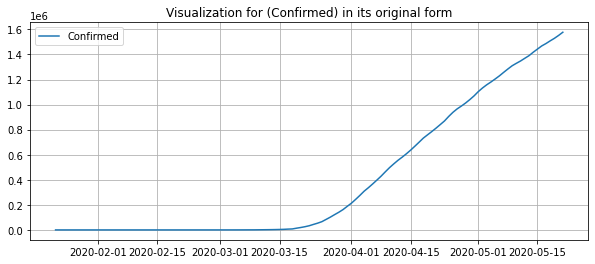

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %df.columns[0])
plt.grid()
plt.show()

In [ ]:
df.tail()

Confirmed
Date                 
2020-05-17    1486757
2020-05-18    1508308
2020-05-19    1528568
2020-05-20    1551853
2020-05-21    1577147

In [ ]:
df_to_test = copy.deepcopy(df)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [ ]:
df_to_test.tail()

Confirmed
Date                 
2020-05-17    1486757
2020-05-18    1508308
2020-05-19    1528568
2020-05-20    1551853
2020-05-21    1577147

In [ ]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [ ]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [ ]:
#Mean absolute percentage error (MAPE) 
def mape(actual, predicted): 
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [ ]:
#Generate all possible combinations of hyperparameters
    
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [ ]:
#Finding the best parameters
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [ ]:
print(column_name)
results = grid_search(df_to_test)

Confirmed
([(0, 0, 0), (0, 0, 0, 365), 'n'], 663642.9698280594, 404039.31404958677)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 663642.9698280594, 404039.31404958677)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 525190.513700741, 457481.8764428659)
([(0, 0, 0), (0, 0, 0, 365), 't'], 313236.09436019015, 272244.3895822906)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 236311.5441773843, 206029.7922634635)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 1157705.6715239692, 700330.5619299596)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 22002743.790443536, 3004015.8701431365)
([(0, 0, 1), (0, 0, 0, 365), 't'], 156355.15474006196, 136502.82488989914)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 14294012.065384591, 12465017.491732296)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 766394.5739390645, 462987.94973706955)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 10901584417.312517, 1058986962.0800629)
([(0, 0, 2), (0, 0, 0, 365), 't'], 81122.58279316015, 70673.47875098244)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 1671184535.9801111, 174476847.7862553)
([(0, 1, 0), (0, 0, 0, 36

In [ ]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Confirmed
[(2, 1, 2), (0, 0, 0, 365), 'ct'] 2169.802842623123 1452.6320518524735


In [ ]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

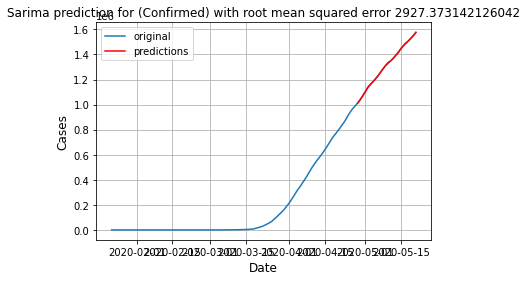

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(test, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cases', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

In [ ]:
mape(test,predictions)

15.104405020852507

In [ ]:
#Recovered Cases in Italy '''

RECOVERED CASES

In [ ]:
q=dataframe.query('Country=="US"')
dfr=q.fillna('').groupby(['Date'])['Recovered'].max()
dfr=pd.DataFrame(dfr)
dfr

Recovered
Date                 
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
...               ...
2020-05-17     272265
2020-05-18     283178
2020-05-19     289392
2020-05-20     294312
2020-05-21     298418

[121 rows x 1 columns]

**Spliting the dataset**

In [ ]:
trainr=dfr[0:97]
testr=dfr[97:]
testr

Recovered
Date                 
2020-04-28     115936
2020-04-29     120720
2020-04-30     153947
2020-05-01     164015
2020-05-02     175382
2020-05-03     180152
2020-05-04     187180
2020-05-05     189791
2020-05-06     189910
2020-05-07     195036
2020-05-08     198993
2020-05-09     212534
2020-05-10     216169
2020-05-11     232733
2020-05-12     230287
2020-05-13     243430
2020-05-14     246414
2020-05-15     250747
2020-05-16     268376
2020-05-17     272265
2020-05-18     283178
2020-05-19     289392
2020-05-20     294312
2020-05-21     298418

In [ ]:
# Series to test
column_name = dfr.columns[0]
print(" %s cases will be used for the analysis" % column_name)

 Recovered cases will be used for the analysis


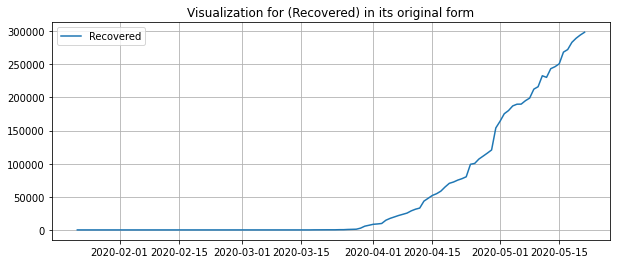

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(dfr, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %dfr.columns[0])
plt.grid()
plt.show()

In [ ]:
dfr.tail()

Recovered
Date                 
2020-05-17     272265
2020-05-18     283178
2020-05-19     289392
2020-05-20     294312
2020-05-21     298418

In [ ]:
df_to_test = copy.deepcopy(dfr)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [ ]:
df_to_test.tail()

Recovered
Date                 
2020-05-17     272265
2020-05-18     283178
2020-05-19     289392
2020-05-20     294312
2020-05-21     298418

In [ ]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [ ]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [ ]:
#Generate all possible combinations of hyperparameters
    
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [ ]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [ ]:
print(column_name)
results = grid_search(df_to_test)

Recovered
([(0, 0, 0), (0, 0, 0, 365), 'n'], 103237.94633073042, 54433.95867768595)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 103237.94633073042, 54433.95867768595)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 87581.55993316283, 69320.12410354483)
([(0, 0, 0), (0, 0, 0, 365), 't'], 61879.55229349783, 51856.301817042724)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 51488.034167566104, 44418.971274175834)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 52517.410942103124, 27581.762321599414)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 46556.82755435445, 36264.204804803194)
([(0, 0, 1), (0, 0, 0, 365), 't'], 109349.23597598252, 89704.22198074886)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 59239.732117030195, 48788.37810958069)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 34505.351076428495, 15084.983633684009)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 28835.500716070816, 22243.345487332102)
([(0, 0, 2), (0, 0, 0, 365), 't'], 75037.40612873252, 57129.198944726435)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 11062035.382361753, 3018930.872272847)
([(0, 1, 0), (0, 0, 0,

In [ ]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Recovered
[(2, 0, 2), (0, 0, 0, 365), 'ct'] 3668.5383023758573 1816.4766070396406


In [ ]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

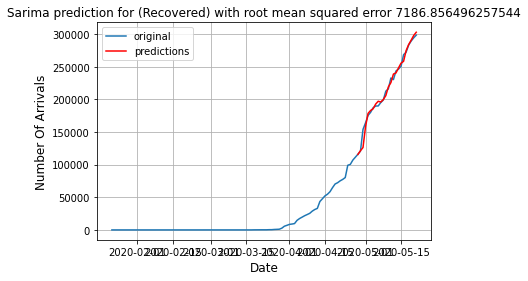

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(testr, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

In [ ]:
mape(testr,predictions)

30.436309852009092

In [ ]:
# Deaths cases

DEATH CASES

In [ ]:
q=dataframe.query('Country=="US"')
dfd=q.fillna('').groupby(['Date'])['Deaths'].max()
dfd=pd.DataFrame(dfd)
dfd

Deaths
Date              
2020-01-22       0
2020-01-23       0
2020-01-24       0
2020-01-25       0
2020-01-26       0
...            ...
2020-05-17   89562
2020-05-18   90347
2020-05-19   91921
2020-05-20   93439
2020-05-21   94702

[121 rows x 1 columns]

In [ ]:
# Series to test
column_name = dfd.columns[0]
print(" %s cases will be used for the analysis" % column_name)

 Deaths cases will be used for the analysis


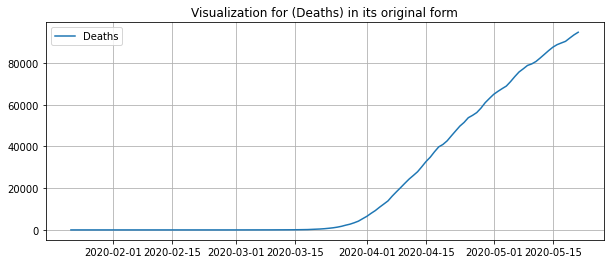

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(dfd, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %dfd.columns[0])
plt.grid()
plt.show()

In [ ]:
dfd.tail()

Deaths
Date              
2020-05-17   89562
2020-05-18   90347
2020-05-19   91921
2020-05-20   93439
2020-05-21   94702

In [ ]:
df_to_test = copy.deepcopy(dfd)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [ ]:
df_to_test.tail()

Deaths
Date              
2020-05-17   89562
2020-05-18   90347
2020-05-19   91921
2020-05-20   93439
2020-05-21   94702

**Spliting the dataset**

In [ ]:
traind=dfd[0:97]
testd=dfd[97:]
testd

Deaths
Date              
2020-04-28   58355
2020-04-29   60967
2020-04-30   62996
2020-05-01   64943
2020-05-02   66369
2020-05-03   67682
2020-05-04   68922
2020-05-05   71064
2020-05-06   73455
2020-05-07   75662
2020-05-08   77180
2020-05-09   78795
2020-05-10   79526
2020-05-11   80682
2020-05-12   82356
2020-05-13   84119
2020-05-14   85898
2020-05-15   87530
2020-05-16   88754
2020-05-17   89562
2020-05-18   90347
2020-05-19   91921
2020-05-20   93439
2020-05-21   94702

In [ ]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [ ]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [ ]:
#Generate all possible combinations of hyperparameters
  
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [ ]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [ ]:
print(column_name)
results = grid_search(df_to_test)

Deaths
([(0, 0, 0), (0, 0, 0, 365), 'n'], 38758.173824134414, 22595.454545454544)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 38758.173824134414, 22595.454545454544)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 31423.271835409167, 26993.498121713)
([(0, 0, 0), (0, 0, 0, 365), 't'], 19902.694166583977, 17296.88926586641)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 15550.076103999125, 13590.547460613785)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 19591.343609740525, 11470.524052572357)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 17200.405425326626, 12439.500281986342)
([(0, 0, 1), (0, 0, 0, 365), 't'], 10071.23653830226, 8795.840833649763)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 9470.901252423811, 7519.974591934571)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 10247.522352103762, 6020.317035755119)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 21414.892616378413, 14068.549678341153)
([(0, 0, 2), (0, 0, 0, 365), 't'], 5367.585079974151, 4695.460923390964)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 9090.349067066689, 7462.175594981874)
([(0, 1, 0), (0, 0, 0, 365),

In [ ]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]
r2 = results[0][3]
print(column_name)
print(best_combination, best_error, mae, r2)

IndexError: ignored

In [ ]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

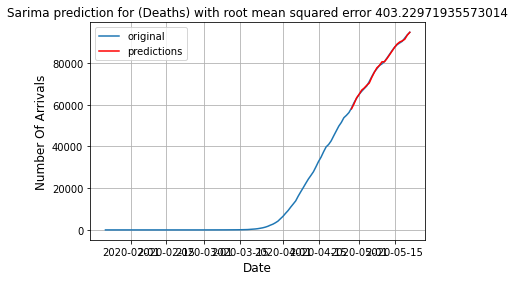

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(testd, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

In [ ]:
mape(testd,predictions)

16.471906166719492